# Read Penn Treebank data

In [6]:
from typing import Dict, List, Tuple
import os
import logging
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader
from nltk.tree import Tree


In [7]:
for parse in BracketParseCorpusReader(root='/home/tony/nltk_data/corpora/pbt/',
                                      fileids = ['test.txt']).parsed_sents():
    print('Example Parsed Sentence \n================================\n',parse)
    
    break

Example Parsed Sentence 
 (S
  (INTJ (RB No))
  (, ,)
  (NP-SBJ (PRP it))
  (VP (VBD was) (RB n't) (NP-PRD (NNP Black) (NNP Monday)))
  (. .))


In [8]:
def strip_functional_tags(tree :Tree) -> None:

    clean_label = tree.label().split('=')[0].split('-')[0].split('|')[0]
    tree.set_label(clean_label)
    for child in tree:
        if not isinstance(child[0],str):
            strip_functional_tags(child)
            

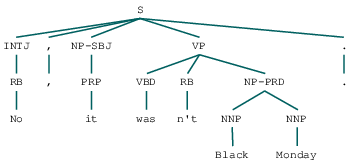

In [9]:
gold_tree

In [10]:
type(gold_tree)
type(gold_tree[0])


nltk.tree.Tree

In [11]:
gold_spans : Dict[Tuple[int,int],str] ={}
get_gold_spans(gold_tree,0,gold_spans)

8

In [12]:
def get_gold_spans(tree: Tree, index : int,
                  typed_spans : Dict[Tuple[int,int],str]) -> int:
    """
    Recursively constructs the gold spans from an nltk "Tree".
    Labels --> constituents
    In case of nested constituents, ans in the case of netsted constituents
    with the same spans, labels are concatenated in parent-child order.
    ex)
    (S (NP (D the) (N man))) would have an s-NP label for the outer span
    """
    #print("inside the loop with  index {}".format(index))
    #print("The tree is : " ,tree)
    
    #NLTK leaves are strings.
    if isinstance(tree[0],str):
        """
        The "length" of a tree is defined by NLTK as  the number of childeren
        
        Spans for leaves (labels are just POS tag) -> don't care
        
        Instead , we just add the length of the owrkd to the end index as 
        we iterate throuhg
        """
        end = index + len(tree)
     #   print("tree is a string:","\ntree value: " , tree[0])
     #   print("the current index : ",end)
        
    else:
        child_start = index
        
      #  print("tree is {} \n".format(type(tree[0])))
      #  print("tree value: ", tree[0])
      #  print("child_start index : " ,child_start)
        
      #  print("================before looping the tree")
        for child in tree:
            #typed_spans is bein updated in place.
       #     print("=============== going deeper ==============")
            end = get_gold_spans(child,child_start,typed_spans)
        #    print("============== going up ===================")
            child_start = end
        # set th end index of the current span to the last appended index -1
        # as span is inclusive.
        #print("-======================after lopping the tree ==================")
        
        span = (index, end-1)
        current_span_label = typed_spans.get(span)
        
        if current_span_label is None:
            typed_spans[span]= tree.label()
        else:
            typed_spans[span] = tree.label()+"-" + current_span_label
            
        #print(tree.label())
        #print("Current span is : " ,span)
        #print("Current span label is : ",current_span_label)
        
        #print("typed_spans : ", typed_spans)
                
    return end
        

In [14]:
from typing import TypeVar,Callable
T = TypeVar("T",str,Token)
def enumerate_spans(sentence: List[T],
                   offset: int=0,
                   max_span_width: int = None,
                   min_span_width: int = 1,
                   filter_function:Callable[[List[T]],bool]=None)->List[Tuple[int,int]]:
    """
    sentence : List[T] 
         The sentence to generate span for

    offset : int 
        numeric offset to add to all span start and end indices.
    filter_function : 
        A function mapping sequence of the passed type T to a boolean value.
        If True the span is included int he returned spans from the sentence
        
    """
    
    max_span_width = max_span_width or len(sentence)
    filter_function = filter_function or (lambda x:True)
    spans: List[Tuple[int,int]]=[]
    
    for start_index in range(len(sentence)):
        last_end_index = min(start_index +max_span_width, len(sentence))
        first_end_index = min(start_index + min_span_width-1,len(sentence))
        
        for end_index in range(first_end_index,last_end_index):
            start = offset + start_index
            end = offset + end_index
            
            if filter_function(sentence[slice(start_index,end_index+1)]):
                spans.append((start,end))
    return spans
    

In [15]:
from allennlp.data.fields import TextField,ListField, SpanField,SequenceLabelField,MetadataField,Field
from allennlp.data import Token
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.instance import Instance
dataset = []
for gold_tree in BracketParseCorpusReader(root='/home/tony/nltk_data/corpora/pbt/',
                                      fileids = ['test.txt']).parsed_sents():
    # need to remove all the functional tags from constituency labels 
    # in an NLTK tree.
    # Also, strip off ansything agter a =, - or | character, because
    # thesea are functional tags which we con't want to use
    
    strip_functional_tags(gold_tree)
    if gold_tree.label() =='VROOT':
        gold_tree = gold_tree[0]
    pos_tags = [x[1] for x in gold_tree.pos()]
    
    tokens = gold_tree.leaves()
    
    # tokens 
    
    text_field = TextField([Token(x) for x in tokens],
                          token_indexers = {'tokens',SingleIdTokenIndexer} )
    fields : Dict[str,Field] = {"tokens": text_field}
        
    # part of speech (pos)
    pos_tag_field = SequenceLabelField(pos_tags,text_field,
                                        label_namespace="pos")

    fields ['pos_tags'] = pos_tag_field
    
    spans: List[Field] = []
    gold_labels =[]
    
    gold_spans : Dict[Tuple[int,int],str] = {}
    get_gold_spans(gold_tree,0,gold_spans)
    
    print(gold_spans)
    
    for start , end in enumerate_spans(tokens):
        spans.append(SpanField(start,end,text_field))
        
        if gold_spans is not None:
            if (start,end) in gold_spans.keys():
                gold_labels.append(gold_spans[(start,end)])
            else:
                gold_labels.append("NO-LABEL")
    
    metadata = {"tokens":tokens}
    if gold_tree:
        metadata["gold_tree"]=gold_tree
    metadata["pos_tags"] = pos_tags
    
    fields["metadata"]=MetadataField(metadata)
    
    span_list_field:ListField = ListField(spans)
    fields['spans'] = span_list_field
    
    fields['span_labels'] = SequenceLabelField(gold_labels,
                                              span_list_field,
                                              label_namespace='labels')
            
                
    dataset.append(Instance(fields))
    
    
    

{(0, 0): 'INTJ', (2, 2): 'NP', (5, 6): 'NP', (3, 6): 'VP', (0, 7): 'S'}
{(2, 6): 'NP', (10, 10): 'ADVP', (11, 11): 'NP', (13, 17): 'NP', (19, 20): 'NP', (22, 22): 'NP', (24, 24): 'NP', (23, 24): 'PP', (26, 28): 'NP', (25, 28): 'PP', (22, 28): 'NP', (21, 29): 'PRN', (19, 29): 'NP', (18, 29): 'VP', (13, 29): 'S', (12, 29): 'SBAR', (9, 29): 'VP', (7, 29): 'VP', (2, 29): 'S', (1, 29): 'SBAR', (30, 30): 'NP', (31, 31): 'ADVP', (33, 33): 'NP', (36, 37): 'NP', (39, 39): 'NP', (38, 39): 'PP', (36, 39): 'NP', (35, 39): 'VP', (34, 39): 'VP', (33, 39): 'S', (32, 39): 'VP', (0, 40): 'S'}
{(0, 4): 'NP', (6, 6): 'NP', (8, 11): 'NP', (7, 11): 'PP', (5, 11): 'VP', (0, 11): 'NP', (13, 15): 'NP', (17, 17): 'NP', (20, 20): 'S', (19, 20): 'SBAR', (18, 20): 'VP', (17, 20): 'S', (16, 21): 'PRN', (22, 22): 'NP', (24, 24): 'NP', (27, 29): 'NP', (31, 34): 'NP', (30, 34): 'PP', (27, 34): 'NP', (26, 34): 'VP', (25, 34): 'VP', (24, 34): 'S', (23, 34): 'ADJP', (22, 34): 'S', (12, 34): 'VP', (0, 35): 'S'}
{(0, 4): 

{(0, 0): 'NP', (2, 2): 'ADVP', (3, 5): 'NP', (7, 8): 'NP', (10, 11): 'NP', (7, 11): 'NP', (6, 11): 'PP', (3, 11): 'NP', (14, 14): 'NP', (16, 17): 'NP', (19, 19): 'NP', (23, 24): 'INTJ', (26, 26): 'NP', (14, 28): 'NP', (13, 28): 'PP', (3, 28): 'NP', (1, 28): 'VP', (0, 29): 'S'}
{(0, 0): 'NP', (1, 1): 'ADVP', (4, 4): 'NP', (7, 7): 'NP', (9, 9): 'VP', (8, 9): 'VP', (7, 9): 'S', (6, 9): 'VP', (5, 9): 'VP', (4, 9): 'S', (3, 9): 'SBAR', (2, 9): 'VP', (0, 10): 'S'}
{(0, 1): 'NP'}
{(2, 2): 'NP', (1, 2): 'PP', (0, 2): 'NAC', (0, 3): 'NP', (6, 6): 'NP', (9, 12): 'NP', (14, 14): 'NP', (15, 15): 'WHNP', (16, 16): 'NP', (20, 20): 'NP', (19, 20): 'VP', (17, 20): 'VP', (16, 20): 'S', (15, 20): 'SBAR', (14, 20): 'NP', (13, 20): 'PP', (8, 20): 'VP', (7, 20): 'VP', (6, 20): 'S', (5, 20): 'NP', (4, 20): 'VP', (0, 21): 'S'}
{(0, 1): 'NP', (4, 5): 'NP', (7, 7): 'NP', (6, 7): 'PP', (4, 7): 'NP', (3, 7): 'PP', (8, 9): 'NP', (11, 11): 'NP', (10, 11): 'PP', (12, 12): 'WHNP', (13, 15): 'NP', (18, 18): 'NP', (19

{(0, 0): 'NP', (2, 3): 'NP', (5, 8): 'NP', (4, 8): 'PP', (10, 11): 'NP', (9, 11): 'PP', (2, 11): 'NP', (1, 11): 'PP', (0, 11): 'NP', (13, 14): 'NP', (15, 15): 'NP', (17, 19): 'NP', (22, 22): 'NP', (25, 27): 'NP', (30, 30): 'NP', (29, 30): 'PP', (28, 30): 'PP', (25, 30): 'NP', (33, 33): 'NP', (35, 35): 'NP', (37, 37): 'NP', (39, 42): 'NP', (38, 42): 'PP', (36, 42): 'VP', (35, 42): 'S', (34, 42): 'PP', (33, 42): 'NP', (31, 42): 'PP', (24, 42): 'VP', (23, 42): 'VP', (22, 42): 'S', (21, 42): 'SBAR', (20, 42): 'VP', (17, 42): 'S', (16, 42): 'SBAR', (12, 42): 'VP', (0, 43): 'S'}
{(0, 1): 'NP', (3, 4): 'NP', (6, 6): 'NP', (5, 6): 'PP', (9, 12): 'NAC', (8, 13): 'NP', (7, 13): 'PP', (3, 13): 'NP', (0, 14): 'NP', (17, 18): 'NP', (16, 18): 'PP', (20, 22): 'NP', (24, 24): 'NP', (23, 24): 'PP', (20, 24): 'NP', (26, 26): 'ADVP', (28, 30): 'NP', (26, 30): 'VP', (20, 31): 'NP', (35, 36): 'NP', (38, 39): 'NP', (37, 39): 'PP', (35, 39): 'NP', (34, 39): 'VP', (33, 39): 'VP', (20, 40): 'S', (19, 40): 'SBA

{(0, 1): 'NP', (4, 4): 'PRT', (5, 6): 'QP', (5, 7): 'NP', (9, 10): 'NP', (8, 10): 'PP', (5, 10): 'NP', (13, 13): 'NP', (17, 17): 'NP', (19, 24): 'NP', (26, 28): 'NP', (25, 28): 'PP', (18, 28): 'VP', (17, 28): 'S', (16, 28): 'PP', (15, 28): 'ADJP', (14, 28): 'VP', (13, 28): 'S', (12, 28): 'SBAR', (3, 28): 'VP', (2, 28): 'VP', (0, 29): 'S'}
{(1, 1): 'NP', (3, 3): 'NP', (5, 7): 'NP', (8, 8): 'WHADVP', (9, 9): 'NP', (12, 13): 'NP', (15, 15): 'NP', (14, 15): 'PP', (16, 16): 'WHNP', (17, 17): 'NP', (20, 21): 'NP', (19, 21): 'VP', (18, 21): 'VP', (17, 21): 'S', (16, 21): 'SBAR', (12, 21): 'NP', (23, 25): 'NP', (27, 28): 'NP', (26, 28): 'PP', (23, 28): 'NP', (22, 28): 'PP', (29, 29): 'ADVP', (11, 29): 'VP', (10, 29): 'VP', (9, 29): 'S', (8, 29): 'SBAR', (5, 29): 'NP', (4, 29): 'PP', (3, 29): 'NP', (2, 29): 'VP', (1, 29): 'S', (32, 33): 'NP', (35, 35): 'S', (34, 35): 'VP', (0, 36): 'S'}
{(0, 0): 'WHADVP', (1, 2): 'NP', (4, 4): 'NP', (3, 4): 'PP', (1, 4): 'NP', (6, 6): 'PRT', (8, 8): 'NP', (7, 8

{(1, 4): 'NP', (6, 6): 'NP', (5, 6): 'VP', (1, 6): 'NP', (0, 6): 'PP', (8, 10): 'NP', (12, 13): 'QP', (12, 14): 'NP', (15, 15): 'PP', (12, 15): 'NP', (17, 18): 'NP', (16, 18): 'PP', (21, 22): 'NP', (24, 24): 'NP', (25, 25): 'ADVP', (27, 27): 'NP', (29, 29): 'WHNP', (30, 30): 'NP', (34, 34): 'NP', (36, 38): 'NP', (35, 38): 'PP', (33, 38): 'VP', (31, 38): 'VP', (30, 38): 'S', (29, 38): 'SBAR', (27, 38): 'NP', (25, 38): 'PP', (23, 38): 'VP', (21, 38): 'S', (20, 38): 'SBAR', (11, 38): 'VP', (0, 39): 'S'}
{(0, 1): 'NP', (2, 2): 'WHNP', (3, 3): 'NP', (7, 9): 'NP', (11, 12): 'NP', (10, 12): 'PP', (7, 12): 'NP', (6, 12): 'VP', (4, 12): 'VP', (3, 12): 'S', (2, 12): 'SBAR', (16, 20): 'NP', (14, 20): 'PP', (0, 21): 'NP', (22, 22): 'ADVP', (25, 25): 'NP', (24, 25): 'VP', (23, 25): 'VP', (0, 26): 'S'}
{(0, 0): 'NP', (2, 3): 'NP', (1, 3): 'PP', (0, 3): 'NP', (6, 7): 'NP', (5, 7): 'PP', (9, 10): 'NP', (12, 13): 'NP', (11, 13): 'PP', (14, 14): 'WHNP', (15, 15): 'NP', (19, 19): 'NP', (18, 19): 'PP', (1

{(0, 0): 'NP', (3, 5): 'NP', (10, 11): 'NP', (9, 11): 'PP', (7, 11): 'ADJP', (6, 11): 'VP', (17, 17): 'NP', (19, 19): 'NP', (21, 22): 'NP', (20, 22): 'VP', (19, 22): 'S', (18, 22): 'PP', (16, 22): 'VP', (15, 22): 'VP', (13, 22): 'VP', (6, 22): 'VP', (3, 22): 'S', (2, 22): 'SBAR', (1, 22): 'VP', (0, 23): 'S'}
{(1, 3): 'NP', (5, 6): 'NP', (4, 6): 'PP', (1, 6): 'NP', (0, 6): 'PP', (8, 10): 'NP', (12, 12): 'PRT', (13, 15): 'NP', (17, 17): 'NP', (16, 17): 'PP', (13, 17): 'NP', (11, 17): 'VP', (0, 18): 'S'}
{(1, 2): 'NP', (5, 5): 'NP', (8, 11): 'NP', (7, 11): 'VP', (6, 11): 'VP', (5, 11): 'S', (4, 11): 'SBAR', (3, 11): 'VP', (1, 11): 'S', (14, 14): 'NP', (16, 16): 'S', (18, 18): 'NP', (20, 23): 'NP', (25, 26): 'NP', (24, 26): 'PP', (19, 26): 'VP', (18, 26): 'S', (15, 26): 'VP', (0, 27): 'S'}
{(2, 2): 'NP', (5, 5): 'NP', (9, 9): 'NP', (11, 15): 'ADJP', (17, 18): 'NP', (20, 20): 'NP', (19, 20): 'PP', (17, 20): 'NP', (11, 20): 'UCP', (10, 20): 'VP', (9, 20): 'S', (8, 20): 'SBAR', (7, 20): 'VP',

{(0, 0): 'NP', (3, 5): 'NP', (7, 7): 'NP', (6, 7): 'PP', (3, 7): 'NP', (2, 7): 'PP', (10, 11): 'QP', (10, 13): 'NP', (17, 18): 'QP', (17, 19): 'NP', (20, 21): 'NP', (17, 21): 'NP', (16, 21): 'PP', (15, 21): 'PP', (10, 21): 'NP', (9, 21): 'PP', (2, 21): 'PP', (1, 21): 'VP', (0, 22): 'S'}
{(0, 0): 'ADVP', (3, 3): 'NP', (5, 5): 'NP', (4, 5): 'VP', (3, 5): 'S', (2, 5): 'SBAR', (7, 7): 'NP', (10, 12): 'NP', (15, 15): 'PRT', (14, 15): 'VP', (13, 15): 'VP', (10, 15): 'S', (9, 15): 'SBAR', (8, 15): 'VP', (19, 21): 'NP', (23, 25): 'NP', (22, 25): 'PP', (19, 25): 'NP', (27, 29): 'QP', (27, 30): 'NP', (31, 32): 'NP', (27, 32): 'NP', (26, 32): 'PP', (34, 36): 'QP', (34, 37): 'NP', (33, 37): 'PP', (18, 37): 'VP', (8, 37): 'VP', (0, 38): 'S'}
{(0, 1): 'NP', (0, 3): 'NP', (5, 6): 'NP', (4, 6): 'PP', (0, 6): 'NP', (8, 10): 'WHNP', (11, 13): 'NP', (17, 17): 'NP', (16, 17): 'VP', (15, 17): 'VP', (14, 17): 'VP', (11, 17): 'S', (8, 17): 'SBAR', (7, 17): 'VP', (20, 24): 'NP', (26, 29): 'QP', (26, 30): 'NP'

{(2, 2): 'NP', (1, 2): 'PP', (0, 2): 'PP', (4, 4): 'NP', (6, 6): 'ADVP', (8, 8): 'NP', (10, 12): 'NP', (14, 14): 'NP', (13, 14): 'PP', (10, 14): 'NP', (9, 14): 'PP', (7, 14): 'VP', (5, 14): 'VP', (0, 15): 'S'}
{(0, 1): 'NP', (4, 5): 'NP', (7, 9): 'NP', (6, 9): 'PP', (4, 9): 'NP', (12, 13): 'ADJP', (11, 16): 'NP', (4, 16): 'NP', (3, 16): 'VP', (2, 16): 'VP', (0, 17): 'S'}
{(0, 1): 'NP', (4, 4): 'NP', (6, 7): 'NP', (9, 13): 'NP', (15, 18): 'NP', (20, 21): 'NP', (20, 23): 'NP', (15, 23): 'NP', (14, 23): 'PP', (9, 23): 'NP', (8, 23): 'PP', (6, 23): 'NP', (5, 23): 'PP', (3, 23): 'VP', (2, 23): 'VP', (28, 28): 'NP', (30, 30): 'NP', (32, 32): 'ADVP', (34, 36): 'NP', (33, 36): 'PP', (31, 36): 'VP', (30, 36): 'S', (29, 36): 'SBAR', (27, 36): 'VP', (26, 36): 'VP', (2, 36): 'VP', (0, 37): 'S'}
{(0, 0): 'ADVP', (2, 2): 'NP', (5, 7): 'NP', (9, 9): 'NP', (11, 14): 'NP', (10, 14): 'PP', (18, 20): 'NP', (22, 25): 'NP', (18, 25): 'NP', (16, 25): 'PP', (9, 25): 'NP', (8, 25): 'PP', (5, 25): 'NP', (4, 25

{(0, 1): 'NP', (4, 4): 'NP', (7, 10): 'QP', (7, 11): 'NP', (12, 13): 'NP', (17, 19): 'QP', (17, 20): 'NP', (22, 22): 'NP', (21, 22): 'PP', (16, 22): 'PP', (15, 22): 'ADVP', (6, 22): 'VP', (5, 22): 'VP', (4, 22): 'S', (3, 22): 'VP', (2, 22): 'VP', (0, 23): 'S'}
{(1, 2): 'NP', (4, 4): 'NP', (1, 5): 'NP', (0, 5): 'PP', (6, 7): 'NP', (9, 10): 'NP', (8, 10): 'PP', (6, 10): 'NP', (13, 15): 'NP', (13, 16): 'NP', (20, 21): 'NP', (19, 21): 'PP', (17, 21): 'VP', (13, 21): 'S', (12, 21): 'SBAR', (11, 21): 'VP', (0, 23): 'S'}
{(0, 1): 'NP', (0, 2): 'NP', (4, 4): 'NP', (7, 7): 'NP', (6, 7): 'PP', (8, 8): 'NP', (11, 12): 'QP', (11, 13): 'NP', (16, 18): 'QP', (15, 19): 'NP', (22, 24): 'NP', (25, 26): 'NP', (22, 26): 'NP', (15, 26): 'NP', (28, 28): 'WHNP', (29, 29): 'NP', (31, 31): 'NP', (33, 35): 'NP', (37, 37): 'NP', (36, 37): 'PP', (33, 37): 'NP', (32, 37): 'PP', (30, 37): 'VP', (29, 37): 'S', (28, 37): 'SBAR', (15, 38): 'NP', (11, 38): 'PP', (10, 38): 'VP', (9, 38): 'VP', (8, 38): 'S', (5, 38): 'V

{(1, 2): 'NP', (4, 6): 'NP', (8, 8): 'NP', (9, 9): 'ADVP', (11, 12): 'NP', (14, 14): 'NP', (13, 14): 'PP', (11, 14): 'NP', (16, 18): 'NP', (15, 18): 'PP', (9, 18): 'VP', (8, 18): 'S', (3, 18): 'VP', (0, 19): 'S'}
{(1, 2): 'NP', (3, 3): 'WHADVP', (4, 5): 'NP', (7, 8): 'NP', (9, 9): 'ADVP', (6, 9): 'VP', (4, 9): 'S', (3, 9): 'SBAR', (1, 9): 'NP', (11, 12): 'NP', (17, 18): 'NP', (16, 18): 'PP', (19, 19): 'NP', (22, 24): 'NP', (21, 24): 'VP', (20, 24): 'VP', (28, 29): 'NP', (27, 29): 'VP', (26, 29): 'VP', (20, 29): 'VP', (19, 29): 'S', (15, 29): 'VP', (14, 29): 'VP', (13, 29): 'VP', (1, 29): 'S', (32, 32): 'NP', (34, 34): 'S', (33, 34): 'VP', (0, 35): 'S'}
{(0, 0): 'ADVP', (3, 4): 'NP', (2, 4): 'PP', (5, 5): 'NP', (9, 9): 'WHADVP', (10, 10): 'NP', (13, 15): 'NP', (12, 15): 'PP', (17, 18): 'NP', (16, 18): 'PP', (19, 19): 'ADVP', (11, 19): 'VP', (10, 19): 'S', (9, 19): 'SBAR', (21, 21): 'NP', (24, 25): 'NP', (29, 30): 'NP', (28, 30): 'PP', (27, 30): 'VP', (26, 30): 'VP', (24, 30): 'S', (23, 

{(0, 1): 'NP', (3, 3): 'NP', (2, 3): 'PP', (0, 3): 'NP', (5, 5): 'NP', (8, 9): 'NX', (11, 11): 'NX', (8, 11): 'NX', (7, 11): 'NP', (6, 11): 'PP', (5, 11): 'NP', (0, 11): 'NP', (14, 15): 'NP', (17, 17): 'NP', (19, 20): 'NP', (18, 20): 'VP', (17, 20): 'S', (16, 20): 'PP', (14, 20): 'NP', (22, 24): 'NP', (26, 27): 'NP', (25, 27): 'PP', (22, 27): 'NP', (21, 27): 'PP', (13, 27): 'VP', (12, 27): 'VP', (0, 28): 'S'}
{(1, 1): 'NP', (4, 4): 'NP', (7, 8): 'ADJP', (6, 10): 'NP', (5, 10): 'PP', (4, 10): 'NP', (3, 10): 'PP', (13, 13): 'NP', (16, 16): 'NP', (17, 17): 'ADVP', (19, 20): 'NP', (18, 20): 'PP', (15, 20): 'VP', (14, 20): 'VP', (13, 20): 'S', (12, 20): 'VP', (0, 21): 'S'}
{(0, 0): 'ADVP', (2, 3): 'NP', (6, 6): 'NP', (8, 10): 'NP', (12, 14): 'NP', (11, 14): 'PP', (7, 14): 'VP', (6, 14): 'S', (16, 16): 'ADJP', (15, 16): 'VP', (6, 16): 'S', (5, 16): 'SBAR', (4, 16): 'VP', (0, 17): 'S'}
{(1, 1): 'NP', (2, 2): 'ADVP', (4, 4): 'NP', (5, 7): 'NP', (2, 7): 'VP', (1, 7): 'S', (12, 12): 'S', (11, 12

{(0, 0): 'NP', (2, 2): 'NP', (4, 4): 'NP', (3, 4): 'VP', (2, 4): 'NP', (1, 4): 'PP', (0, 4): 'NP', (7, 9): 'QP', (7, 10): 'NP', (12, 12): 'NP', (11, 12): 'PP', (6, 12): 'VP', (5, 12): 'VP', (0, 13): 'S'}
{(0, 2): 'NP', (5, 5): 'NP', (7, 7): 'NP', (6, 7): 'PP', (9, 9): 'NP', (8, 9): 'PP', (12, 15): 'NP', (11, 15): 'PP', (10, 15): 'ADVP', (17, 17): 'NP', (19, 19): 'NP', (22, 23): 'NP', (21, 23): 'VP', (20, 23): 'VP', (19, 23): 'S', (18, 23): 'VP', (17, 23): 'S', (16, 23): 'PP', (4, 23): 'VP', (0, 24): 'NP', (27, 27): 'NP', (29, 29): 'NP', (31, 32): 'NP', (30, 32): 'PP', (29, 32): 'NP', (28, 32): 'PP', (27, 32): 'NP', (35, 35): 'NP', (34, 35): 'PP', (33, 35): 'VP', (27, 35): 'S', (26, 35): 'SBAR', (25, 35): 'VP', (0, 36): 'S'}
{(0, 1): 'NP', (4, 4): 'NP', (5, 6): 'NP', (8, 10): 'NP', (7, 10): 'PP', (3, 10): 'VP', (0, 11): 'NP', (14, 14): 'NP', (16, 17): 'NP', (16, 19): 'NP', (21, 22): 'NP', (20, 22): 'PP', (16, 22): 'NP', (15, 22): 'PP', (13, 22): 'VP', (12, 22): 'VP', (0, 23): 'S'}
{(0, 

{(0, 1): 'NP', (7, 8): 'FRAG-ADJP', (6, 8): 'SBAR', (5, 9): 'PRN', (4, 10): 'NP', (3, 10): 'VP', (2, 10): 'VP', (0, 11): 'S'}
{(1, 2): 'ADJP', (0, 4): 'NP', (7, 9): 'NP', (6, 9): 'PP', (5, 9): 'VP', (0, 10): 'S'}
{(0, 2): 'NP', (5, 5): 'NP', (3, 5): 'PP', (9, 9): 'NP', (11, 11): 'NP', (9, 12): 'S', (8, 12): 'VP', (15, 15): 'NP', (17, 19): 'NP', (16, 19): 'PP', (14, 19): 'VP', (8, 19): 'VP', (0, 19): 'NP', (22, 24): 'NP', (26, 26): 'NP', (25, 26): 'PP', (28, 28): 'WHNP', (29, 29): 'NP', (32, 34): 'NP', (37, 37): 'NP', (39, 42): 'NP', (38, 42): 'PP', (36, 42): 'VP', (35, 42): 'VP', (32, 42): 'S', (31, 42): 'SBAR', (30, 42): 'VP', (29, 42): 'S', (28, 42): 'SBAR', (22, 42): 'NP', (21, 42): 'VP', (0, 43): 'S'}
{(1, 1): 'NP', (5, 7): 'NP', (4, 8): 'PRN', (10, 11): 'NP', (15, 17): 'NX', (13, 18): 'NP', (20, 20): 'NP', (22, 24): 'NP', (21, 24): 'PP', (19, 24): 'VP', (13, 24): 'NP', (12, 24): 'PP', (10, 24): 'NP', (0, 24): 'NP', (27, 27): 'ADJP', (29, 29): 'NP', (28, 29): 'PP', (26, 29): 'VP', 

{(0, 0): 'ADVP', (2, 2): 'NP', (4, 6): 'NP', (8, 8): 'WHNP', (9, 9): 'NP', (11, 13): 'NP', (15, 16): 'NP', (14, 16): 'PP', (11, 16): 'NP', (10, 16): 'VP', (9, 16): 'S', (8, 16): 'SBAR', (4, 17): 'NP', (3, 17): 'PP', (2, 17): 'NP', (19, 19): 'NP', (21, 22): 'NP', (23, 23): 'ADVP', (21, 23): 'NP', (20, 23): 'PP', (19, 23): 'NP', (18, 23): 'VP', (0, 24): 'S'}
{(1, 1): 'NP', (3, 3): 'NP', (2, 3): 'VP', (5, 5): 'ADVP', (7, 7): 'PRT', (8, 8): 'NP', (5, 8): 'VP', (2, 8): 'VP', (1, 8): 'S', (12, 12): 'S', (11, 12): 'VP', (13, 14): 'NP', (16, 17): 'NP', (19, 21): 'NP', (18, 21): 'PP', (16, 21): 'NP', (13, 21): 'NP', (0, 22): 'SINV'}
{(0, 1): 'NP', (4, 4): 'NP', (5, 5): 'ADVP', (8, 11): 'NP', (13, 14): 'NP', (16, 16): 'NP', (19, 20): 'ADJP', (18, 23): 'NP', (17, 23): 'PP', (16, 23): 'NP', (13, 23): 'NP', (12, 23): 'PP', (8, 23): 'NP', (7, 23): 'PP', (6, 23): 'VP', (4, 23): 'S', (3, 23): 'SBAR', (2, 23): 'VP', (0, 24): 'S'}
{(0, 0): 'NP', (2, 2): 'NP', (5, 5): 'NP', (7, 8): 'NP', (9, 10): 'NP', (

{(1, 2): 'ADVP', (4, 5): 'NP', (7, 7): 'NP', (9, 10): 'NP', (13, 14): 'NP', (12, 14): 'PP', (19, 19): 'NP', (21, 23): 'NP', (21, 24): 'NP', (26, 26): 'NP', (25, 26): 'PP', (21, 26): 'NP', (28, 29): 'NP', (21, 29): 'NP', (20, 29): 'VP', (19, 29): 'S', (18, 29): 'PP', (17, 29): 'ADJP', (16, 29): 'VP', (9, 29): 'S', (8, 29): 'SBAR', (6, 29): 'VP', (0, 30): 'S'}
{(0, 0): 'NP', (5, 6): 'NP', (8, 8): 'NP', (10, 10): 'ADVP', (11, 11): 'NP', (13, 13): 'NP', (15, 17): 'NP', (19, 21): 'NP', (23, 23): 'NP', (22, 23): 'PP', (19, 23): 'NP', (18, 23): 'PP', (15, 23): 'NP', (14, 23): 'PP', (13, 23): 'NP', (12, 23): 'PP', (11, 23): 'NP', (9, 23): 'VP', (8, 23): 'S', (7, 23): 'VP', (5, 23): 'S', (4, 23): 'SBAR', (3, 23): 'VP', (1, 23): 'VP', (0, 24): 'S'}
{(0, 1): 'NP', (4, 5): 'NP', (7, 9): 'NP', (6, 9): 'PP', (4, 9): 'NP', (3, 9): 'PP', (13, 13): 'NP', (16, 16): 'PRT', (15, 16): 'VP', (20, 20): 'PRT', (19, 20): 'VP', (15, 21): 'VP', (14, 21): 'VP', (13, 21): 'S', (23, 23): 'NP', (25, 25): 'VP', (24, 

{(1, 2): 'NP', (5, 5): 'NP', (7, 7): 'S', (6, 7): 'VP', (5, 7): 'S', (3, 8): 'PRN', (13, 13): 'WHNP', (14, 16): 'NP', (19, 19): 'NP', (18, 19): 'PP', (17, 19): 'VP', (14, 19): 'S', (13, 19): 'SBAR', (11, 19): 'NP', (10, 19): 'VP', (0, 21): 'S'}
{(0, 2): 'NP'}
{(0, 0): 'NP', (1, 3): 'NP', (5, 8): 'NP', (4, 8): 'PP', (1, 8): 'NP', (0, 8): 'S', (10, 11): 'NP', (14, 14): 'NP', (17, 18): 'NP', (21, 22): 'NP', (20, 22): 'PP', (19, 22): 'ADVP', (24, 26): 'NP', (23, 26): 'PP', (16, 26): 'VP', (15, 26): 'VP', (14, 26): 'S', (13, 26): 'VP', (12, 26): 'VP', (0, 27): 'S'}
{(0, 1): 'NP', (0, 3): 'NP', (5, 5): 'NP', (8, 8): 'S', (7, 8): 'SBAR', (6, 8): 'VP', (5, 8): 'S', (4, 9): 'PRN', (13, 14): 'NP', (11, 14): 'VP', (0, 15): 'S'}
{(0, 0): 'NP', (2, 4): 'NP', (7, 7): 'NP', (8, 8): 'WHNP', (9, 9): 'NP', (12, 14): 'NP', (11, 14): 'PP', (10, 14): 'VP', (9, 14): 'S', (8, 14): 'SBAR', (7, 14): 'NP', (6, 14): 'PP', (2, 14): 'NP', (1, 14): 'VP', (0, 15): 'S'}
{(0, 0): 'ADVP', (4, 6): 'NP', (3, 6): 'PP', (2

{(0, 0): 'NP', (1, 1): 'SBAR', (0, 1): 'NP', (4, 5): 'NP', (7, 8): 'NP', (7, 9): 'ADJP', (10, 10): 'SBAR', (7, 10): 'ADJP', (11, 11): 'ADVP', (13, 13): 'NP', (15, 15): 'ADJP', (16, 17): 'NP', (16, 18): 'ADVP', (14, 18): 'VP', (13, 18): 'S', (12, 18): 'SBAR', (6, 18): 'VP', (4, 18): 'S', (3, 18): 'SBAR', (2, 18): 'VP', (0, 18): 'S', (20, 20): 'NP', (23, 23): 'S', (22, 23): 'SBAR', (21, 23): 'VP', (0, 24): 'S'}
{(0, 1): 'NP', (3, 3): 'NP', (5, 7): 'NP', (9, 10): 'NP', (8, 10): 'PP', (5, 10): 'NP', (12, 12): 'WHNP', (13, 13): 'NP', (15, 19): 'NP', (14, 19): 'VP', (13, 19): 'S', (12, 19): 'SBAR', (5, 20): 'NP', (4, 20): 'PP', (3, 20): 'NP', (0, 20): 'NP', (24, 25): 'NP', (27, 27): 'NP', (26, 27): 'PP', (24, 27): 'NP', (23, 27): 'PP', (29, 29): 'NP', (30, 30): 'ADVP', (32, 33): 'NP', (34, 36): 'NP', (32, 36): 'S', (31, 36): 'VP', (23, 36): 'S', (22, 36): 'SBAR', (21, 36): 'VP', (0, 38): 'S'}
{(1, 2): 'NP', (4, 4): 'NP', (3, 4): 'PP', (1, 4): 'NP', (6, 6): 'ADJP', (5, 6): 'VP', (1, 6): 'S', 

{(1, 2): 'NP', (8, 8): 'NP', (12, 13): 'NP', (11, 13): 'PP', (10, 13): 'ADJP', (9, 13): 'VP', (8, 13): 'S', (7, 13): 'SBAR', (4, 13): 'NP', (3, 13): 'VP', (1, 13): 'S', (16, 18): 'NP', (19, 19): 'WHADVP', (20, 20): 'NP', (23, 23): 'NP', (24, 24): 'ADVP', (22, 24): 'VP', (21, 24): 'VP', (20, 24): 'S', (19, 24): 'SBAR', (16, 24): 'NP', (27, 28): 'NP', (30, 30): 'NP', (29, 30): 'PP', (27, 30): 'NP', (33, 34): 'NP', (37, 38): 'NP', (36, 38): 'PP', (32, 38): 'VP', (31, 38): 'VP', (27, 38): 'S', (26, 38): 'SBAR', (25, 38): 'VP', (16, 38): 'S', (1, 38): 'S', (40, 42): 'NP', (44, 44): 'NP', (46, 47): 'NP', (43, 48): 'PRN', (40, 48): 'NP', (52, 52): 'S', (51, 52): 'SBAR', (53, 53): 'NP', (50, 53): 'VP', (0, 54): 'S'}
{(0, 3): 'NP', (5, 7): 'NP', (4, 7): 'PP', (0, 7): 'NP', (9, 10): 'WHNP', (11, 11): 'NP', (14, 16): 'NP', (19, 19): 'NP', (18, 19): 'VP', (17, 19): 'VP', (14, 19): 'S', (13, 19): 'SBAR', (12, 19): 'VP', (11, 19): 'S', (9, 19): 'SBAR', (0, 20): 'NP', (23, 26): 'NP', (29, 32): 'NP', 

{(0, 4): 'NP', (6, 6): 'NP', (7, 8): 'NP', (10, 10): 'NP', (14, 15): 'NP', (17, 18): 'NP', (20, 21): 'NP', (23, 24): 'NP', (22, 24): 'PP', (20, 24): 'NP', (26, 27): 'NP', (25, 27): 'PP', (20, 27): 'NP', (19, 27): 'PP', (17, 27): 'NP', (16, 27): 'PP', (14, 27): 'NP', (13, 27): 'VP', (11, 27): 'VP', (10, 27): 'S', (9, 27): 'SBAR', (5, 27): 'VP', (0, 28): 'S'}
{(0, 4): 'NP', (6, 7): 'NP', (9, 9): 'NP', (11, 11): 'NP', (14, 15): 'NP', (17, 18): 'NP', (16, 18): 'PP', (14, 18): 'NP', (20, 23): 'NP', (19, 23): 'PP', (14, 23): 'NP', (25, 26): 'NP', (28, 28): 'NP', (30, 34): 'NP', (29, 34): 'PP', (27, 34): 'VP', (25, 34): 'NP', (14, 34): 'NP', (13, 34): 'VP', (12, 34): 'VP', (11, 34): 'S', (10, 34): 'VP', (9, 34): 'S', (8, 34): 'SBAR', (5, 34): 'VP', (0, 35): 'S'}
{(0, 2): 'NP', (5, 5): 'NP', (8, 9): 'NP', (11, 13): 'NP', (15, 15): 'NP', (14, 15): 'PP', (11, 15): 'NP', (10, 15): 'PP', (8, 15): 'NP', (17, 17): 'NP', (19, 19): 'NP', (21, 21): 'NP', (20, 21): 'VP', (19, 21): 'S', (18, 21): 'VP', (

{(0, 1): 'NP', (3, 3): 'NP', (2, 3): 'PP', (0, 3): 'NP', (6, 10): 'QP', (6, 11): 'NP', (12, 13): 'NP', (6, 13): 'NP', (5, 13): 'PP', (4, 13): 'VP', (0, 14): 'S'}
{(0, 1): 'NP', (0, 2): 'ADVP', (4, 5): 'NP', (7, 8): 'NP', (10, 12): 'QP', (10, 13): 'NP', (16, 18): 'NP', (19, 20): 'NP', (16, 20): 'NP', (10, 20): 'NP', (9, 20): 'PP', (7, 20): 'NP', (23, 23): 'NP', (25, 27): 'QP', (25, 28): 'NP', (24, 28): 'PP', (23, 28): 'NP', (22, 28): 'PP', (7, 28): 'NP', (6, 28): 'VP', (0, 29): 'S'}
{(0, 0): 'NP', (2, 2): 'NP', (4, 4): 'VP', (3, 4): 'VP', (2, 4): 'S', (1, 4): 'VP', (0, 5): 'S'}
{(1, 3): 'NP', (6, 6): 'NP', (8, 9): 'NP', (11, 13): 'NP', (10, 13): 'PP', (8, 13): 'NP', (7, 13): 'PP', (5, 13): 'VP', (4, 13): 'VP', (0, 14): 'S'}
{(1, 2): 'NP', (4, 5): 'NP', (3, 5): 'PP', (8, 9): 'NP', (7, 9): 'PP', (3, 9): 'PP', (1, 9): 'NP', (0, 9): 'PP', (11, 13): 'NP', (16, 17): 'NP', (15, 17): 'PP', (19, 19): 'WHNP', (20, 20): 'NP', (23, 24): 'NP', (22, 24): 'VP', (21, 24): 'VP', (20, 24): 'S', (19, 24):

In [18]:
dataset

 ...]

In [17]:
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch

# Vocabulary
vocab = Vocabulary.from_instances(dataset)

  0%|          | 0/2416 [00:00<?, ?it/s]


AttributeError: 'set' object has no attribute 'values'

In [ ]:
#Converted the indexed dataset into Pytorch Variables
batch = Batch(dataset)
tensors = batch.as_tensor_dict(batch.get_padding_lengths())
print("torch tensors for passing to a model: \n\n", tensors)

In [ ]:
    for start , end in enumerate_spans(tokens):
        spans.append(SpanField(start,end,text_field))
        
        if gold_spans is not None:
            if (start,end) in gold_spans.keys():
                gold_labels.append(gold_spans[(start,end)])
            else:
                gold_labels.append("NO-LABEL")

In [ ]:
metadata

In [ ]:
fields

In [20]:
isinstance(dataset,list)

True